<a href="https://www.kaggle.com/code/soheybfarohe/distelbert-fine-tuned-f1-sc-1-000-isot-dataset?scriptVersionId=152460132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


**loading libraries here**

In [2]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.30.1
Uninstalling transformers-4.30.1:
  Successfully uninstalled transformers-4.30.1
Found existing installation: accelerate 0.12.0
Uninstalling accelerate-0.12.0:
  Successfully uninstalled accelerate-0.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 41.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 22.5 MB/s eta 0:00:00


In [3]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [4]:
from transformers import AdamW, TrainingArguments
from accelerate import Accelerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
!pip install klib

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import numpy as np
from datasets import load_metric
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
# from torch import nn
# import torch.nn.functional as F
import torch
import re
import string
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import klib as kb 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [7]:
dftrue = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
dffalse = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

In [8]:
dftrue.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
dftrue.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [10]:
dftrue['category'] = 1 # true label
dffalse['category'] = 0 # fake lable

In [11]:
dftrue.head(7)

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1


In [12]:
dffalse.head(7)

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0


In [13]:
label_dict={'fake':0,'true':1}

In [14]:
dftrue.isna().sum() # no missing values 

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [15]:
dffalse.isna().sum() 

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [16]:
df_full = pd.concat([dftrue,dffalse])

In [17]:
df_full.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


GridSpec(6, 4)

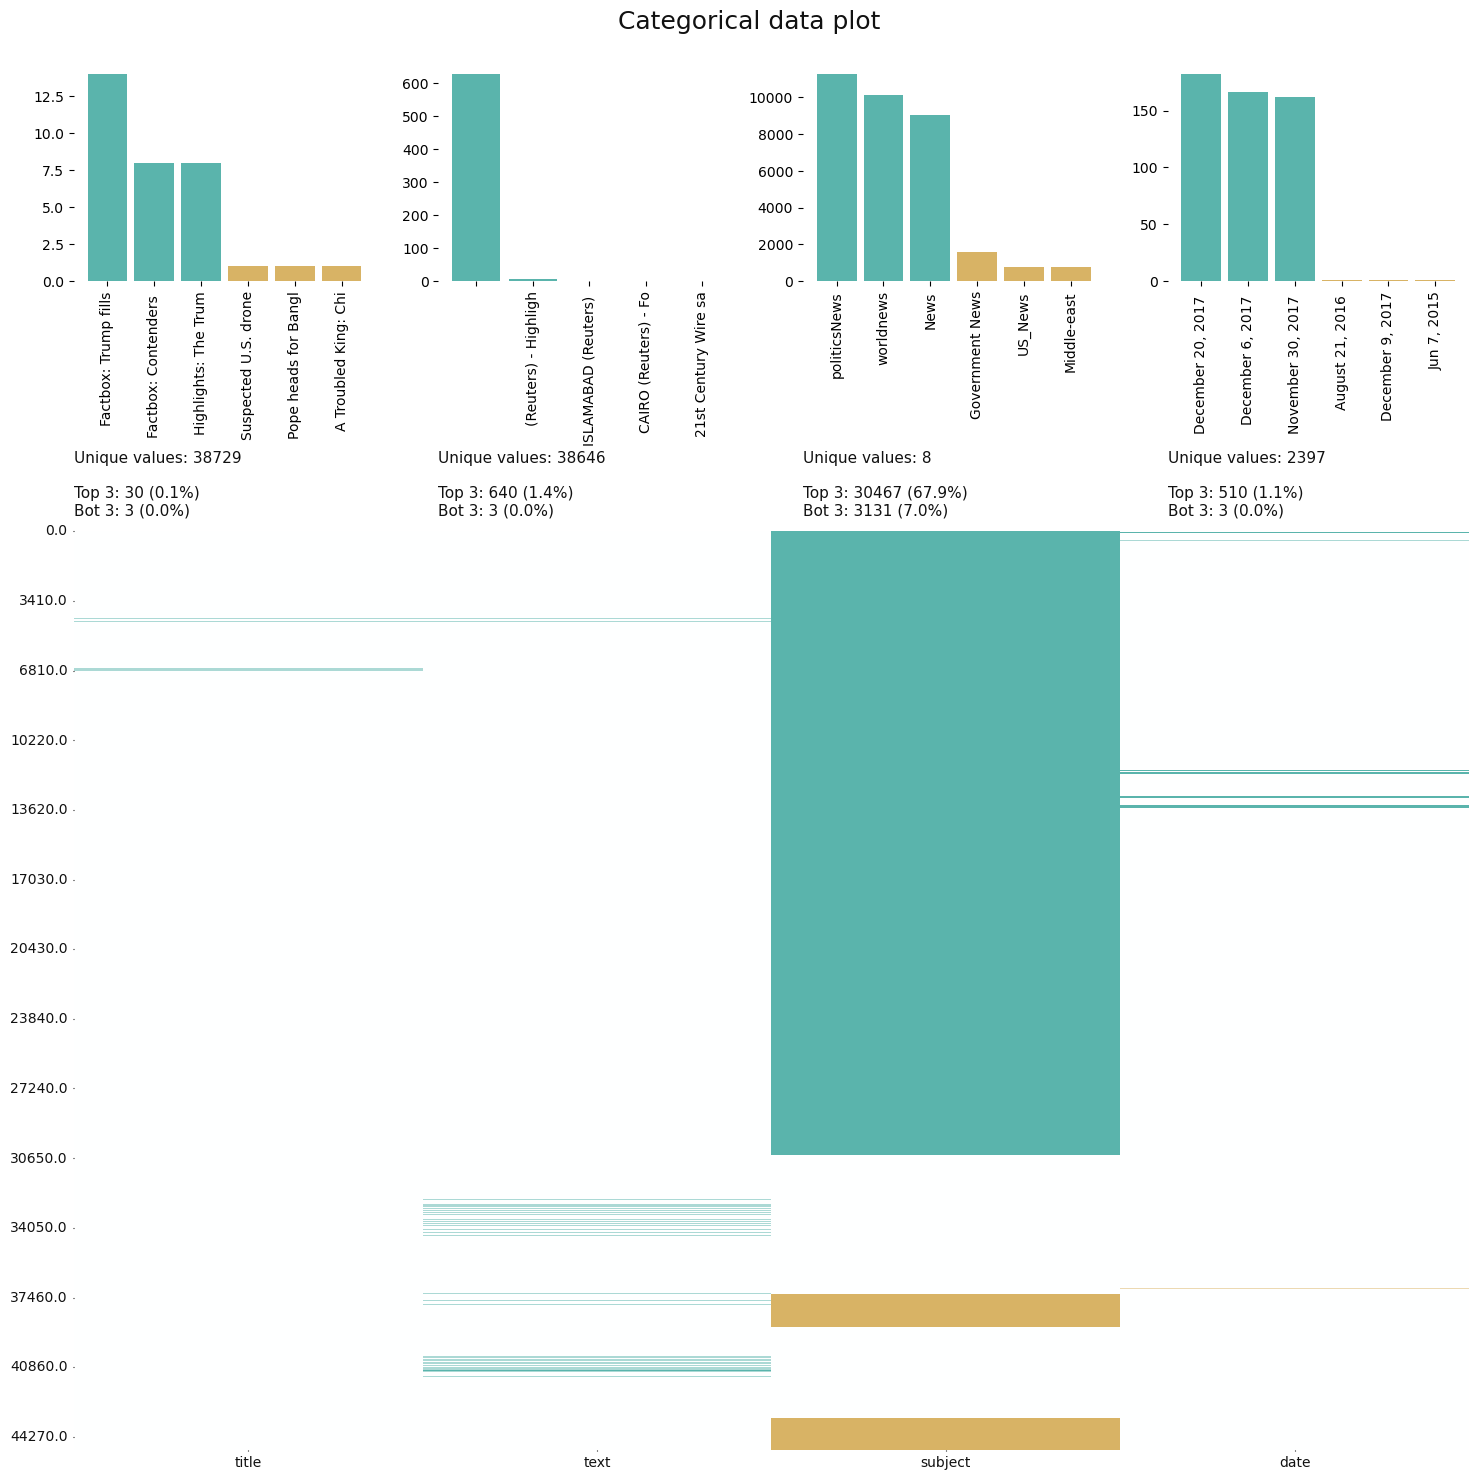

In [18]:
kb.cat_plot(df_full)

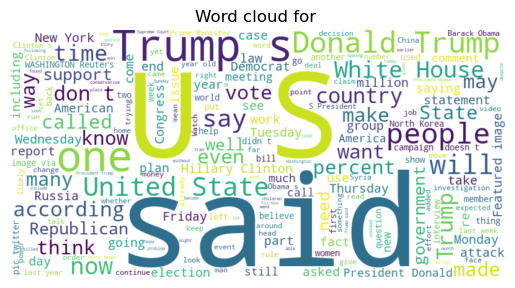

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_word_cloud_from_df(df, text_column_name):
    # Extract the text data from the specified column in the dataframe
    text_data = df[text_column_name].tolist()

    # Combine the text data into a single string
    combined_text = ' '.join(text_data)

    # Create a WordCloud object with some customization options
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(combined_text)

    # Create a figure and axes object
    fig, ax = plt.subplots()
    ax.set_title('Word cloud for ', loc='center')
    # Display the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()
    # Show the plot
    plt.show()
create_word_cloud_from_df(df_full,text_column_name='text')

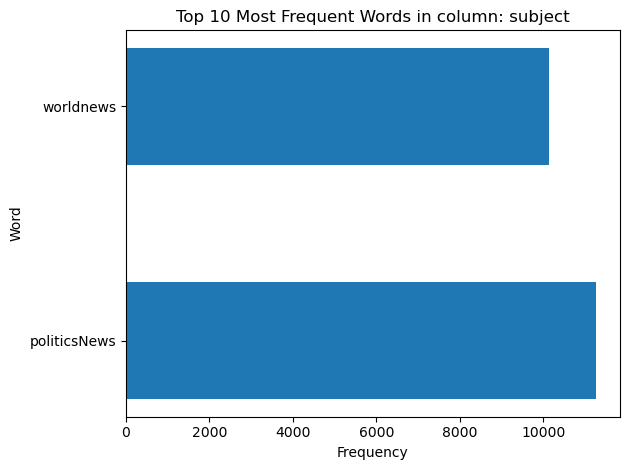

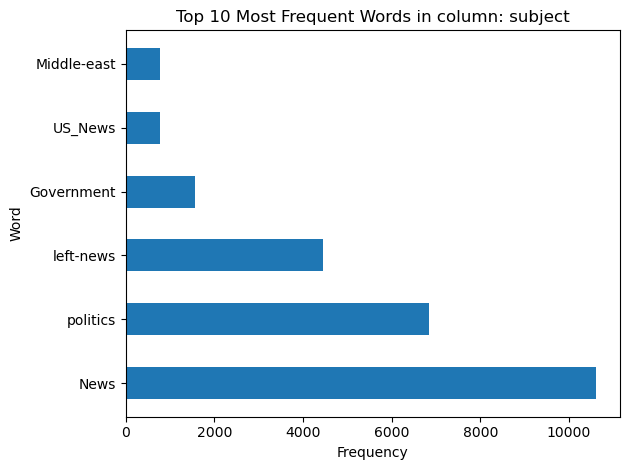

In [20]:
import nltk
from nltk.probability import FreqDist


def plot_most_frequent_words(df, text_column_name, n=10):
    # Extract the text data from the specified column in the dataframe
    text_data = df[text_column_name].tolist()

    # Combine the text data into a single string
    combined_text = ' '.join(text_data)

    # Tokenize the text into words
    words = nltk.tokenize.word_tokenize(combined_text)

    # Create a frequency distribution of the words
    freq_dist = FreqDist(words)

    # Get the most frequent words
    top_words = freq_dist.most_common(n)

    # Create a bar plot of the top N most frequent words with increased spacing
    fig, ax = plt.subplots()
    ax.barh([word[0] for word in top_words], [word[1] for word in top_words], height=0.5)
    ax.set_title(f'Top {n} Most Frequent Words in column: {text_column_name}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')
    plt.tight_layout()
    plt.show()
plot_most_frequent_words(dftrue,text_column_name = 'subject')
plot_most_frequent_words(dffalse,text_column_name = 'subject')



In [21]:


true_train, true_test = train_test_split(dftrue, test_size=0.3, random_state=42)
false_train, false_test = train_test_split(dffalse, test_size=0.3, random_state=42)


In [22]:
print(true_train.shape)
print(false_train.shape)
print(true_test.shape)
print(false_test.shape)



(14991, 5)
(16436, 5)
(6426, 5)
(7045, 5)


**balanced dataset**

In [23]:



# Concatenate the dataframes vertically
train = pd.concat([true_train, false_train], axis=0).reset_index(drop=True)


test = pd.concat([true_test, false_test], axis=0).reset_index(drop=True)
# Shuffle the concatenated dataframe
train = shuffle(train)
test = shuffle(test)


In [24]:
train.head()

,title,text,subject,date,category
17653,Idiot Donald Trump Supporter Confronts Ted Cr...,It s a pretty well-known fact among those who ...,News,"May 2, 2016",0
18872,REPORT: Chaos Reigns Inside The White House A...,Donald Trump can t handle the complexity of ru...,News,"February 13, 2017",0
18991,Georgia Republican Ruthlessly Blocks Rape Kit...,Proving once again that Republicans don t care...,News,"March 16, 2016",0
11113,Two ex-Trump aides head to U.S. court on charg...,"WASHINGTON (Reuters) - Paul Manafort, who serv...",politicsNews,"November 2, 2017",1
22269,ECONOMIC SYSTEMS BRILLIANTLY EXPLAINED WITH COWS,Share this with everyone! There s a good reaso...,politics,"Apr 16, 2016",0


In [25]:
train.shape

(31427, 5)

In [26]:
test.shape

(13471, 5)

In [27]:
test.category

10139    0
11509    0
10115    0
9301     0
2116     1
        ..
11851    0
12986    0
9731     0
4056     1
12038    0
Name: category, Length: 13471, dtype: int64

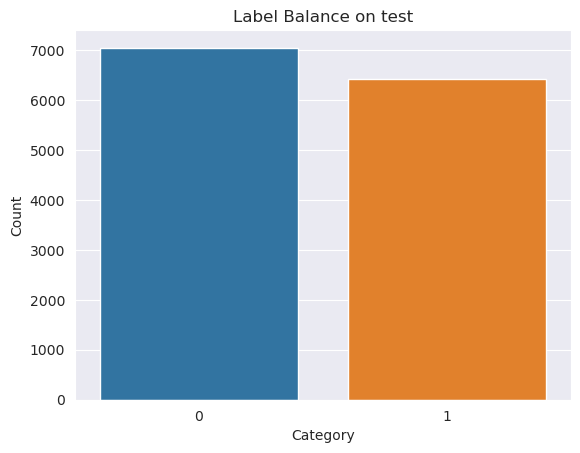

In [28]:


# Set the style of the plot
sns.set_style("darkgrid")

# Plot the label balance using countplot
sns.countplot(data=test, x='category')

# Set the axis labels and title
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Label Balance on test")

# Display the plot
plt.show()


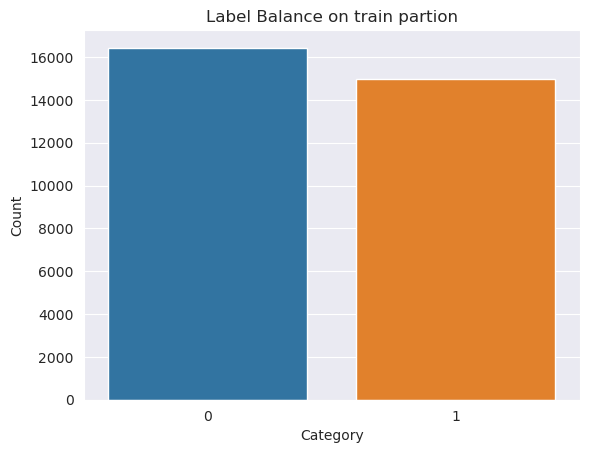

In [29]:


# Assuming you have the label counts stored in the 'label_counts' variable

# Set the style of the plot
sns.set_style("darkgrid")

# Plot the label balance using countplot
sns.countplot(data=train, x='category')

# Set the axis labels and title
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Label Balance on train partion")

# Display the plot
plt.show()


# conclusion : balanced dataset

# preprocessing data

In [30]:
train.text[14164]

'ANKARA (Reuters) - Leading Turkish and U.S. businesses urged the governments of Turkey and the United States on Tuesday to resolve a series of diplomatic rows that have prompted both countries to cut back on issuing visas to each other s citizens. Turkey has fumed over what it sees as U.S. reluctance to extradite Muslim cleric Fethullah Gulen, accused by Ankara of  orchestrating an abortive military coup last year, and over U.S. support for the Syrian Kurdish YPG militia, seen by Turks as an extension of the outlawed Kurdistan Workers Party (PKK).  Gulen denies any connection with the coup bid. The Turkish-U.S. Business Council (TAIK) called on the U.S. and Turkish governments to engage in talks to resolve the rows and prevent harm to both of their economies and citizens.  We call on the governments of Turkey and America to enter into discussions to reach a meaningful resolution to the existing differences   so that neither of our peoples or economies suffer,  TAIK said in a statement

In [31]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation,
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', ' ', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)  # Remove links
    text = re.sub(r'<.*?>+', ' ', text)  # Remove HTML tags
    text = re.sub(r'[{}]+'.format(re.escape(string.punctuation)), ' ', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newline characters
    text = re.sub(r'[.]', ' ', text)  # Remove period
    return text


In [32]:
train.text = train.text.map(clean_text)

test.text = test.text.map(clean_text)




In [33]:
def add_cls_token(df, content_column='content', subject_column='subject', title_column='title', text_column='text', date_column='date'):
    # Add the desired text and separator
    text_sep = "content is"
    title_sep = "title is"
    additional_text = " [SEP], "

    # Concatenate the columns into the 'content' column
    df[content_column] = "[CLS] at " +df[date_column]+additional_text+ df[subject_column] + additional_text+ title_sep + df[title_column] + additional_text+ text_sep + " " + df[text_column]+ additional_text+" ."

    return df


In [34]:
train.head()

,title,text,subject,date,category
17653,Idiot Donald Trump Supporter Confronts Ted Cr...,it s a pretty well known fact among those who ...,News,"May 2, 2016",0
18872,REPORT: Chaos Reigns Inside The White House A...,donald trump can t handle the complexity of ru...,News,"February 13, 2017",0
18991,Georgia Republican Ruthlessly Blocks Rape Kit...,proving once again that republicans don t care...,News,"March 16, 2016",0
11113,Two ex-Trump aides head to U.S. court on charg...,washington reuters paul manafort who serv...,politicsNews,"November 2, 2017",1
22269,ECONOMIC SYSTEMS BRILLIANTLY EXPLAINED WITH COWS,share this with everyone there s a good reaso...,politics,"Apr 16, 2016",0


In [35]:
train2= add_cls_token(train)
test2 = add_cls_token(test)

In [36]:
train2.text[14164]

'ankara  reuters    leading turkish and u s  businesses urged the governments of turkey and the united states on tuesday to resolve a series of diplomatic rows that have prompted both countries to cut back on issuing visas to each other s citizens  turkey has fumed over what it sees as u s  reluctance to extradite muslim cleric fethullah gulen  accused by ankara of  orchestrating an abortive military coup last year  and over u s  support for the syrian kurdish ypg militia  seen by turks as an extension of the outlawed kurdistan workers party  pkk   gulen denies any connection with the coup bid  the turkish u s  business council  taik  called on the u s  and turkish governments to engage in talks to resolve the rows and prevent harm to both of their economies and citizens   we call on the governments of turkey and america to enter into discussions to reach a meaningful resolution to the existing differences   so that neither of our peoples or economies suffer   taik said in a statement 

In [37]:
test2.content[6792]

'[CLS] at January 9, 2016 [SEP], News [SEP], title is Watch What Happens When a Muslim Woman Shows Up At A Donald Trump Rally (VIDEO) [SEP], content is donald trump has managed to attract the most racist and islamophobic of american voters  that was all on display in rock hill  south carolina  at a friday night campaign rally when a muslim woman  56 year old rose hamid  was thrown out by trump security  rose  dressed in traditional islamic dress and a t shirt that read  i come in peace   was sitting in the stands directly behind trump when trump supporters  at the urging of his campaign staff  began to chant trump s name after rose stood up when trump suggested that syrian refugees were affiliated with isis  rose simply stood up and stayed silent when she began to be heckled  which eventually led to her removal by trump s security hamid later said that she  came to the rally to let trump supporters see what a muslim looks like so i figured that i d give them the opportunity to meet one

# Transfomers part 

In [38]:

# tokenizer = AutoTokenizer.from_pretrained('jy46604790/Fake-News-Bert-Detect')
# model = AutoModel.from_pretrained('jy46604790/Fake-News-Bert-Detect', num_labels=2)

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

path="distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(path)

model = AutoModelForSequenceClassification.from_pretrained(path)


In [40]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [41]:
 model.to('cuda')

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [42]:
train3 = train2[['content', 'category']]
test3 = test2[['content', 'category']]


In [43]:
train3.rename(columns={'category': 'labels'}, inplace=True)
test3.rename(columns={'category': 'labels'}, inplace=True)

/tmp/ipykernel_29/1689929004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train3.rename(columns={'category': 'labels'}, inplace=True)
/tmp/ipykernel_29/1689929004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3.rename(columns={'category': 'labels'}, inplace=True)


In [44]:
test3.head()

,content,labels
10139,"[CLS] at October 27, 2017 [SEP], News [SEP], t...",0
11509,"[CLS] at Dec 26, 2015 [SEP], politics [SEP], t...",0
10115,"[CLS] at May 16, 2017 [SEP], News [SEP], title...",0
9301,"[CLS] at January 11, 2016 [SEP], News [SEP], t...",0
2116,"[CLS] at September 23, 2016 [SEP], politicsNe...",1


In [45]:
from datasets import Dataset ,DatasetDict
dataset_dict = DatasetDict({
    "train": Dataset.from_dict(train3),
    "test": Dataset.from_dict(test3)
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['content', 'labels'],
        num_rows: 31427
    })
    test: Dataset({
        features: ['content', 'labels'],
        num_rows: 13471
    })
})

In [46]:
def tokenize_function(example):
    return tokenizer(example['content'],
                     max_length=128,
                     pad_to_max_length=True,
                     truncation=True,
                     add_special_tokens=False
                    )


In [47]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

  0%|          | 0/32 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?ba/s]

In [48]:
from transformers import AutoTokenizer, DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [49]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['content', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 31427
    })
    test: Dataset({
        features: ['content', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 13471
    })
})

In [50]:

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [51]:
import torch.optim as optim
from transformers import TrainingArguments

learning_rate = 0.0005

training_args = TrainingArguments(
    "test_trainer",
    num_train_epochs=2,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    report_to="tensorboard",
    eval_accumulation_steps=1,
    load_best_model_at_end=True,
    disable_tqdm=False,
    optim="adafactor"
)

# # Define the optimizer
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)



In [52]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



# Accuracy-score 1.000 ,F1-score 1.000

In [53]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.000000,1.000000,1.000000
2,0.012600,0.000000,1.000000,1.000000


TrainOutput(global_step=984, training_loss=0.006395228550989087, metrics={'train_runtime': 464.0632, 'train_samples_per_second': 135.443, 'train_steps_per_second': 2.12, 'total_flos': 2081526468781056.0, 'train_loss': 0.006395228550989087, 'epoch': 2.0})

In [54]:
test_dataset = tokenized_datasets["test"]



# Perform the evaluation using trainer.predict
pred_results = trainer.predict(test_dataset)

# Get the predicted labels and true labels
predicted_labels = pred_results.predictions.argmax(axis=1)
true_labels = pred_results.label_ids



# Calculate the F1 score, precision, and recall
classification_rep = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7045
           1       1.00      1.00      1.00      6426

    accuracy                           1.00     13471
   macro avg       1.00      1.00      1.00     13471
weighted avg       1.00      1.00      1.00     13471



In [55]:

confusion_mat = confusion_matrix(true_labels, predicted_labels)


In [56]:
predicted_labels

array([0, 0, 0, ..., 0, 1, 0])

Text(95.72222222222221, 0.5, 'Actual')

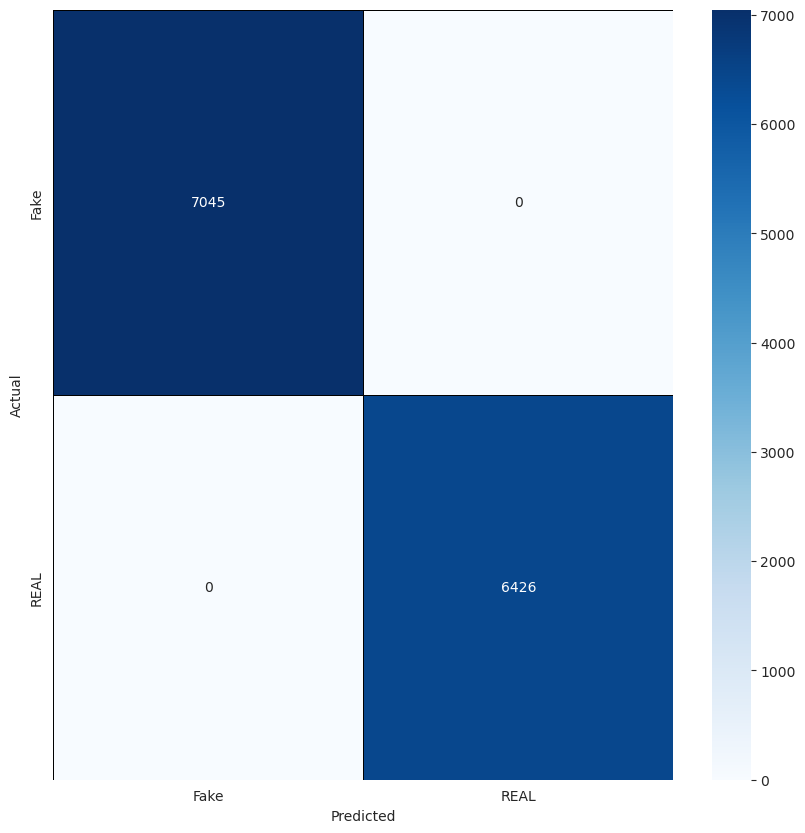

In [57]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion_mat,cmap= "Blues", linecolor = 'black' , linewidth = 0.7 , annot = True, fmt='' , xticklabels = ['Fake','REAL'] , yticklabels = ['Fake','REAL'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [58]:
import torch
import pandas as pd

def extract_dense_768_vectors(dataset, model):
    # Set the model to evaluation mode
    model.eval()

    # Create a new column in the dataset to store the extracted vectors
    dataset['dense_768_representation'] = None

    with torch.no_grad():
        # Iterate through each row in the dataset
        for idx, row in dataset.iterrows():
            # Extract input_ids and attention_mask values from the row and convert to tensors
            input_ids = torch.tensor(row['input_ids'], dtype=torch.long).unsqueeze(0).cuda()
            attention_mask = torch.tensor(row['attention_mask'], dtype=torch.long).unsqueeze(0).cuda()

            # Forward pass through the model to get the dense_768 output
            distilbert_output = model.distilbert(input_ids=input_ids, attention_mask=attention_mask)
            hidden_state = distilbert_output.last_hidden_state

            dense_output = model.pre_classifier(hidden_state[:, 0, :])
            dense_output = dense_output.cpu()

            # Store the dense_768 output as a vector in the dataset
            dataset.at[idx, 'dense_768_representation'] = dense_output.detach().numpy().squeeze()

    return dataset


In [59]:

train_plus_latent_representation= pd.DataFrame(data=tokenized_datasets["train"])
test_plus_latent_representation= pd.DataFrame(data=tokenized_datasets["test"])

In [60]:
train_plus_latent_representation

,content,labels,input_ids,attention_mask
0,"[CLS] at May 2, 2016 [SEP], News [SEP], title ...",0,"[101, 2012, 2089, 1016, 1010, 2355, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[CLS] at February 13, 2017 [SEP], News [SEP], ...",0,"[101, 2012, 2337, 2410, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[CLS] at March 16, 2016 [SEP], News [SEP], tit...",0,"[101, 2012, 2233, 2385, 1010, 2355, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[CLS] at November 2, 2017 [SEP], politicsNews...",1,"[101, 2012, 2281, 1016, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[CLS] at Apr 16, 2016 [SEP], politics [SEP], t...",0,"[101, 2012, 19804, 2385, 1010, 2355, 102, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
31422,"[CLS] at November 14, 2017 [SEP], worldnews [...",1,"[101, 2012, 2281, 2403, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
31423,"[CLS] at October 12, 2017 [SEP], worldnews [S...",1,"[101, 2012, 2255, 2260, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
31424,"[CLS] at August 16, 2016 [SEP], politicsNews ...",1,"[101, 2012, 2257, 2385, 1010, 2355, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
31425,"[CLS] at January 7, 2016 [SEP], News [SEP], ti...",0,"[101, 2012, 2254, 1021, 1010, 2355, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [61]:
test_plus_latent_representation = extract_dense_768_vectors(test_plus_latent_representation, model)

In [62]:
test_plus_latent_representation

,content,labels,input_ids,attention_mask,dense_768_representation
0,"[CLS] at October 27, 2017 [SEP], News [SEP], t...",0,"[101, 2012, 2255, 2676, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.340493, -0.5891283, -1.4767157, 0.9488164, ..."
1,"[CLS] at Dec 26, 2015 [SEP], politics [SEP], t...",0,"[101, 2012, 11703, 2656, 1010, 2325, 102, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.2836007, -0.5800004, -1.4546541, 0.9320947,..."
2,"[CLS] at May 16, 2017 [SEP], News [SEP], title...",0,"[101, 2012, 2089, 2385, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.3757051, -0.6778932, -1.4801344, 0.8971001,..."
3,"[CLS] at January 11, 2016 [SEP], News [SEP], t...",0,"[101, 2012, 2254, 2340, 1010, 2355, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.3412082, -0.6091576, -1.4226564, 0.9383468,..."
4,"[CLS] at September 23, 2016 [SEP], politicsNe...",1,"[101, 2012, 2244, 2603, 1010, 2355, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.3187647, -0.24680369, 3.7113662, -0.241000..."
...,...,...,...,...,...
13466,"[CLS] at February 5, 2017 [SEP], News [SEP], t...",0,"[101, 2012, 2337, 1019, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.3150158, -0.55973524, -1.4221541, 1.0057127..."
13467,"[CLS] at February 28, 2017 [SEP], News [SEP], ...",0,"[101, 2012, 2337, 2654, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.3853024, -0.6207055, -1.5376343, 0.9614594,..."
13468,"[CLS] at March 29, 2016 [SEP], News [SEP], tit...",0,"[101, 2012, 2233, 2756, 1010, 2355, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.3945937, -0.63732743, -1.4771878, 0.937123,..."
13469,"[CLS] at October 1, 2017 [SEP], worldnews [SE...",1,"[101, 2012, 2255, 1015, 1010, 2418, 102, 1010,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.29084495, -0.20076773, 3.7000828, -0.27751..."


In [63]:
train_plus_latent_representation = extract_dense_768_vectors(train_plus_latent_representation, model)

In [64]:
train_plus_latent_representation['dense_768_representation'][0].shape

(768,)

In [65]:
x_train=train_plus_latent_representation['dense_768_representation'].apply(pd.Series).astype(float)
y_train=train_plus_latent_representation['labels']

x_test=test_plus_latent_representation['dense_768_representation'].apply(pd.Series).astype(float)
y_test=test_plus_latent_representation['labels']


In [66]:
x_test

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.340493,-0.589128,-1.476716,0.948816,0.836952,-0.776054,-0.451139,-0.204810,1.185170,1.770042,...,1.250647,-0.257059,0.334372,0.907725,1.362556,-0.407821,-0.422575,0.847673,-0.346771,-0.089866
1,1.283601,-0.580000,-1.454654,0.932095,0.920950,-0.766578,-0.517116,-0.140666,1.301163,1.681901,...,1.109150,-0.199714,0.303868,0.901373,1.403166,-0.500579,-0.392185,0.980331,-0.398826,-0.040638
2,1.375705,-0.677893,-1.480134,0.897100,0.926243,-0.825265,-0.385421,-0.237104,1.236702,1.773330,...,1.193481,-0.233088,0.396043,0.921876,1.348221,-0.403174,-0.449740,0.806691,-0.265882,-0.146116
3,1.341208,-0.609158,-1.422656,0.938347,0.780533,-0.807070,-0.435115,-0.206323,1.163892,1.937810,...,1.304912,-0.210253,0.357087,0.954914,1.460725,-0.476500,-0.376311,0.942132,-0.364007,-0.117003
4,-0.318765,-0.246804,3.711366,-0.241001,-0.339590,2.007792,-0.161271,1.279378,-1.010063,-0.239813,...,-0.536288,-0.320034,-0.330456,-0.500463,-0.713909,1.166199,-0.349343,-0.080004,1.773330,-0.508950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13466,1.315016,-0.559735,-1.422154,1.005713,0.842659,-0.820425,-0.500785,-0.138231,1.303251,1.841997,...,1.205747,-0.196779,0.349992,0.961656,1.472184,-0.459056,-0.440588,0.930716,-0.347522,-0.077201
13467,1.385302,-0.620705,-1.537634,0.961459,0.824125,-0.781047,-0.510342,-0.183459,1.246709,1.916702,...,1.308198,-0.236341,0.365909,0.942273,1.448345,-0.543465,-0.382027,0.986699,-0.361335,-0.052728
13468,1.394594,-0.637327,-1.477188,0.937123,0.854545,-0.820686,-0.466001,-0.182370,1.232069,1.938643,...,1.323244,-0.181928,0.328849,1.067112,1.472082,-0.521733,-0.342807,0.926597,-0.341425,-0.069673
13469,-0.290845,-0.200768,3.700083,-0.277511,-0.291405,2.058578,-0.220889,1.293692,-1.062405,-0.228843,...,-0.500684,-0.327760,-0.359647,-0.525982,-0.707825,1.220638,-0.308361,-0.095365,1.838627,-0.482091


In [67]:

# Define the models
logreg_classifier = LogisticRegression()
nb_classifier = GaussianNB()
svm_classifier = SVC(probability=True)
xgboost_classifier = XGBClassifier(n_estimators=500, learning_rate=0.1)

# Fit the models
logreg_classifier.fit(x_train, y_train)
nb_classifier.fit(x_train, y_train)
svm_classifier.fit(x_train, y_train)
xgboost_classifier.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)])

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.59816
[1]	validation_0-logloss:0.52037
[2]	validation_0-logloss:0.45549
[3]	validation_0-logloss:0.40065
[4]	validation_0-logloss:0.35381
[5]	validation_0-logloss:0.31345
[6]	validation_0-logloss:0.27845
[7]	validation_0-logloss:0.24792
[8]	validation_0-logloss:0.22117
[9]	validation_0-logloss:0.19763
[10]	validation_0-logloss:0.17685
[11]	validation_0-logloss:0.15846
[12]	validation_0-logloss:0.14213
[13]	validation_0-logloss:0.12761
[14]	validation_0-logloss:0.11466
[15]	validation_0-logloss:0.10311
[16]	validation_0-logloss:0.09278
[17]	validation_0-logloss:0.08354
[18]	validation_0-logloss:0.07526
[19]	validation_0-logloss:0.06783
[20]	validation_0-logloss:0.06116
[21]	validation_0-logloss:0.05516
[22]	validation_0-logloss:0.04977
[23]	validation_0-logloss:0.04492
[24]	validation_0-logloss:0.04056
[25]	validation_0-logloss:0.03662
[26]	validation_0-logloss:0.03308
[27]	validation_0-logloss:0.02989
[28]	validation_0-logloss:0.02701
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [68]:
models = {'Logistic Regression': logreg_classifier,
          'Naive Bayes': nb_classifier,
          'SVM': svm_classifier,
          'XGBoost': xgboost_classifier}

metrics = ['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc']

results = {}
for name, model in models.items():
    # Predict the labels for the validation set
    y_pred = model.predict(x_test)
    
    # Calculate the metrics
    metrics_values = [accuracy_score(y_test, y_pred),
                      precision_score(y_test, y_pred, zero_division=0),
                      recall_score(y_test, y_pred),
                      f1_score(y_test, y_pred),
                      roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])]
    
    # Store the results
    results[name] = dict(zip(metrics, metrics_values))

# Print the results
print("Classification metrics:\n")
print("{:<20} {:<10} {:<10} {:<10} {:<10} {:<10}".format('', *metrics))
for name, result in results.items():
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(name, 
          result['accuracy'], result['precision'], result['recall'], result['f1-score'], result['roc_auc']))

Classification metrics:

                     accuracy   precision  recall     f1-score   roc_auc   
Logistic Regression  1.0000     1.0000     1.0000     1.0000     1.0000    
Naive Bayes          1.0000     1.0000     1.0000     1.0000     1.0000    
SVM                  1.0000     1.0000     1.0000     1.0000     1.0000    
XGBoost              1.0000     1.0000     1.0000     1.0000     1.0000    


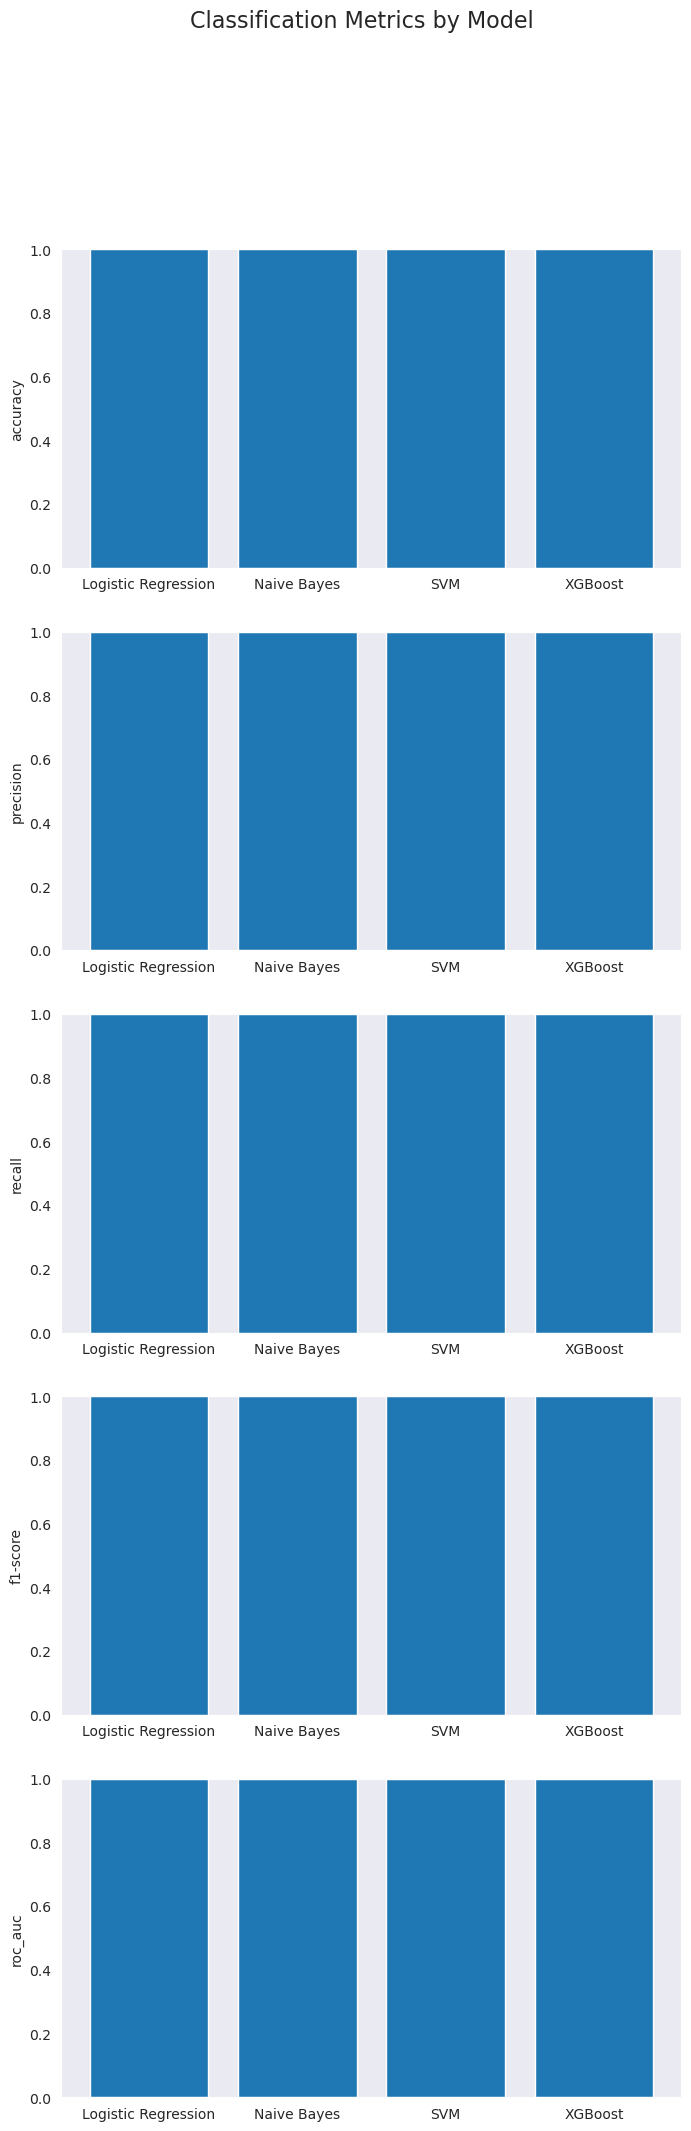

In [69]:

# Define the models and metrics
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'XGBoost']
metrics = ['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc']

# Create a figure with subplots for each metric
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 24))

# Loop through each metric and create a bar chart for each model
for i, metric in enumerate(metrics):
    axs[i].bar(models, [results[model][metric] for model in models])
    axs[i].set_ylim([0, 1])
    axs[i].set_ylabel(metric)
    axs[i].grid(axis='y')

# Add a title to the figure
fig.suptitle('Classification Metrics by Model', fontsize=16)

# Display the figure
plt.show()

In [70]:

models = {'Logistic Regression': logreg_classifier,
          'Naive Bayes': nb_classifier,
          'SVM': svm_classifier,
          'XGBoost': xgboost_classifier}

# Create a dictionary to store the confusion matrices
confusion_matrices = {}

for name, model in models.items():
    # Predict the labels for the validation set
    y_pred = model.predict(x_test)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Store the confusion matrix
    confusion_matrices[name] = cm

# Print the confusion matrices
for name, cm in confusion_matrices.items():
    print("Confusion matrix for", name)
    print(cm)
    print()


Confusion matrix for Logistic Regression
[[7045    0]
 [   0 6426]]

Confusion matrix for Naive Bayes
[[7045    0]
 [   0 6426]]

Confusion matrix for SVM
[[7045    0]
 [   0 6426]]

Confusion matrix for XGBoost
[[7045    0]
 [   0 6426]]



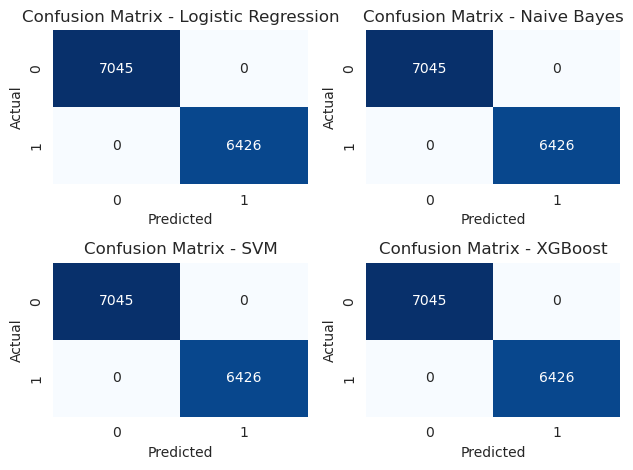

In [71]:

for i, (name, cm) in enumerate(confusion_matrices.items()):
    plt.subplot(2, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()


# using CNN model

In [72]:

num_rows = 24
num_cols = 32



In [73]:
num_rows = 24
num_cols = 32
# because we have 768 vector
x_test_matrices = np.array([row.reshape((num_rows, num_cols)) for row in x_test.values])
x_train_matrices =np.array([row.reshape((num_rows, num_cols)) for row in x_train.values])

In [74]:
x_test_matrices.shape

(13471, 24, 32)

In [75]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Reshape the arrays to have a fourth dimension for color channels
x_train_reshaped = np.reshape(x_train_matrices, (-1, num_rows, num_cols, 1))
x_test_reshaped = np.reshape(x_test_matrices, (-1, num_rows, num_cols, 1))

# Map binary labels to the range [0, 1]
y_train_mapped = y_train.astype(int)
y_test_mapped = y_test.astype(int)
# Split the training data into training and validation sets
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train_reshaped, y_train_mapped, test_size=0.2, random_state=42)

# Convert the mapped labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_split)
y_valid_one_hot = to_categorical(y_valid_split)
y_test_one_hot = to_categorical(y_test_mapped)
# Define the batch size
batch_size = 32


In [76]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()

model = Sequential()
model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(24, 32, 1)))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="valid"))
model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="valid"))
model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="valid"))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=2, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 32, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 24, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 32, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 16, 256)      0         
 )                                                               
                                                      

In [77]:
from tensorflow import keras
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

In [79]:
# Train the model
history = model.fit(x_train_split, y_train_one_hot,
                    epochs=15,
                    batch_size=batch_size,
                    validation_data=(x_valid_split, y_valid_one_hot),
                    callbacks=[early_stopping])

Epoch 1/15


2023-07-06 14:03:49.041048: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


786/786 [==============================] - 23s 18ms/step - loss: 8.7094e-04 - accuracy: 0.9997 - val_loss: 3.5148e-07 - val_accuracy: 1.0000
Epoch 2/15
786/786 [==============================] - 13s 17ms/step - loss: 6.1407e-07 - accuracy: 1.0000 - val_loss: 1.0431e-07 - val_accuracy: 1.0000
Epoch 3/15
786/786 [==============================] - 13s 17ms/step - loss: 3.8512e-07 - accuracy: 1.0000 - val_loss: 6.9787e-08 - val_accuracy: 1.0000
Epoch 4/15
786/786 [==============================] - 13s 17ms/step - loss: 2.7583e-07 - accuracy: 1.0000 - val_loss: 5.5112e-08 - val_accuracy: 1.0000
Epoch 5/15
786/786 [==============================] - 14s 17ms/step - loss: 2.2657e-07 - accuracy: 1.0000 - val_loss: 4.5285e-08 - val_accuracy: 1.0000
Epoch 6/15
786/786 [==============================] - 13s 17ms/step - loss: 1.9443e-07 - accuracy: 1.0000 - val_loss: 3.7967e-08 - val_accuracy: 1.0000
Epoch 7/15
786/786 [==============================] - 13s 17ms/step - loss: 1.6662e-07 - accuracy: 

In [80]:
def plot_history(history):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

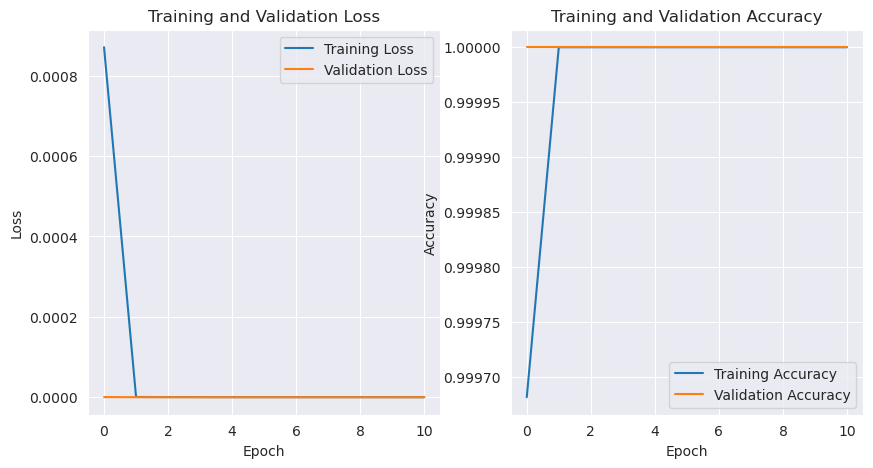

In [81]:
plot_history(history)

In [82]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test_one_hot)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


421/421 [==============================] - 3s 8ms/step - loss: 3.8330e-07 - accuracy: 1.0000
Test Loss: 3.833025061794615e-07
Test Accuracy: 1.0


In [83]:

# Convert one-hot encoding to class labels
y_test_labels = np.argmax(y_test_one_hot, axis=1)
# predict classes for test set
valid_y_pred = model.predict(x_test_reshaped)
y_pred_classes = np.argmax(valid_y_pred, axis=1)

# create confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_classes)
print(cm)

421/421 [==============================] - 2s 5ms/step
[[7045    0]
 [   0 6426]]


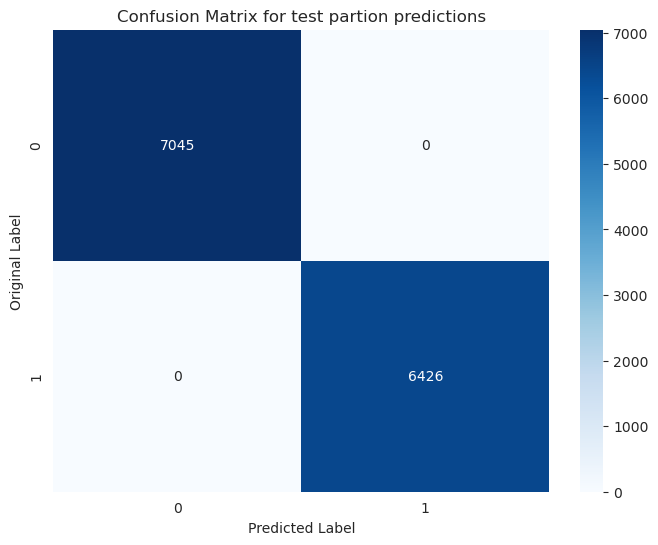

In [84]:
fig, ax = plt.subplots(figsize=(8, 6))

# Create the confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)

# Set the axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Original Label')

# Set the title
ax.set_title('Confusion Matrix for test partion predictions')

# Show the plot

plt.show()